# 📋 Estructura del Proyecto - 5 Etapas

Este notebook está organizado en 5 etapas claramente definidas para facilitar su comprensión y ejecución:

## 🔧 Etapa 1: Configuración y Descarga de Datos
- Instalación de dependencias necesarias (PyTorch, scikit-learn, etc.)
- Verificación de GPU y configuración del dispositivo
- Descarga automática del dataset 20 Newsgroups

## 📊 Etapa 2: Preprocesamiento y Análisis Exploratorio
- Análisis del dataset de noticias
- Limpieza y preprocesamiento de texto
- Creación de vocabulario y vectorización

## 🏗️ Etapa 3: Arquitectura del Modelo
- Implementación de modelo TF-IDF con SVM
- Definición de modelo con embeddings y PyTorch
- Configuración de optimizadores y funciones de pérdida

## 🚀 Etapa 4: Entrenamiento
- Entrenamiento de ambos modelos por 5 épocas
- Comparación de rendimiento en tiempo real
- Guardado de los mejores modelos

## 📈 Etapa 5: Evaluación y Resultados
- Evaluación comparativa de ambos modelos
- Análisis de clasificación y matrices de confusión
- Visualización de métricas de rendimiento

---

# Clasificación de Noticias - 20 Newsgroups
## Framework: PyTorch con NLP
### Clasificar artículos en 20 categorías temáticas usando Bag of Words vs Embeddings

In [20]:
# Verificar GPU disponible
!nvidia-smi

# Instalar dependencias
!python -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!python -m pip install scikit-learn nltk transformers
!python -m pip install matplotlib seaborn wordcloud
!python -m pip install tqdm pandas numpy

Sat Jun 28 11:43:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8              8W /   85W |    3108MiB /   4096MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.2 requires numpy<2.3,>=1.24, but you have numpy 2.3.1 which is incompatible.


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import string
from collections import Counter
from wordcloud import WordCloud
from tqdm import tqdm
import time
import pickle

# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memoria GPU disponible: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

# Configurar seeds
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cuda
GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Memoria GPU disponible: 4.0 GB


[nltk_data] Downloading package punkt to C:\Users\Cristhian
[nltk_data]     Ismael\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Cristhian
[nltk_data]     Ismael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Cristhian
[nltk_data]     Ismael\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 📊 ETAPA 2: PREPROCESAMIENTO Y ANÁLISIS EXPLORATORIO
---

Descargando dataset 20 Newsgroups...

Categorías (20):
 0. alt.atheism
 1. comp.graphics
 2. comp.os.ms-windows.misc
 3. comp.sys.ibm.pc.hardware
 4. comp.sys.mac.hardware
 5. comp.windows.x
 6. misc.forsale
 7. rec.autos
 8. rec.motorcycles
 9. rec.sport.baseball
10. rec.sport.hockey
11. sci.crypt
12. sci.electronics
13. sci.med
14. sci.space
15. soc.religion.christian
16. talk.politics.guns
17. talk.politics.mideast
18. talk.politics.misc
19. talk.religion.misc

Datos de entrenamiento: 11314 documentos
Datos de test: 7532 documentos

=== EJEMPLO DE DOCUMENTO ===
Categoría: rec.autos
Texto: I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I k...


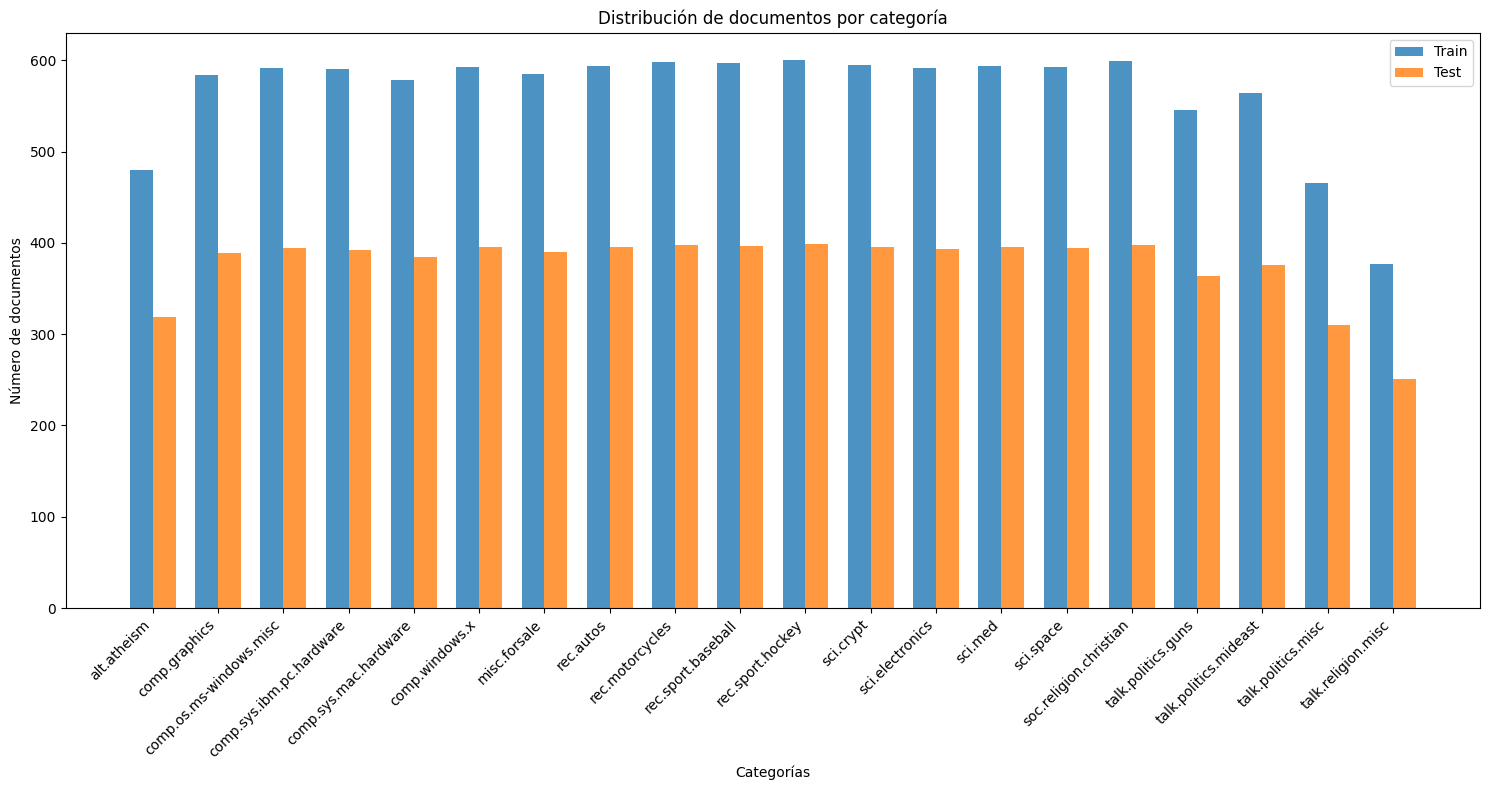

In [22]:
# Cargar dataset 20 Newsgroups
print("Descargando dataset 20 Newsgroups...")

# Cargar datos de entrenamiento y test
newsgroups_train = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

newsgroups_test = fetch_20newsgroups(
    subset='test',
    remove=('headers', 'footers', 'quotes'),
    random_state=42
)

# Información del dataset
print(f"\nCategorías ({len(newsgroups_train.target_names)}):")
for i, category in enumerate(newsgroups_train.target_names):
    print(f"{i:2d}. {category}")

print(f"\nDatos de entrenamiento: {len(newsgroups_train.data)} documentos")
print(f"Datos de test: {len(newsgroups_test.data)} documentos")

# Explorar algunos ejemplos
print("\n=== EJEMPLO DE DOCUMENTO ===")
idx = 0
print(f"Categoría: {newsgroups_train.target_names[newsgroups_train.target[idx]]}")
print(f"Texto: {newsgroups_train.data[idx][:300]}...")

# Distribución de clases
plt.figure(figsize=(15, 8))
categories = [newsgroups_train.target_names[i] for i in range(len(newsgroups_train.target_names))]
train_counts = np.bincount(newsgroups_train.target)
test_counts = np.bincount(newsgroups_test.target)

x = np.arange(len(categories))
width = 0.35

plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.xlabel('Categorías')
plt.ylabel('Número de documentos')
plt.title('Distribución de documentos por categoría')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Preprocesamiento de texto
class TextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
    
    def clean_text(self, text):
        """Limpiar y normalizar texto"""
        # Convertir a minúsculas
        text = text.lower()
        
        # Remover URLs, emails y patrones especiales
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'\d+', '', text)  # Remover números
        
        # Remover puntuación
        text = text.translate(str.maketrans('', '', string.punctuation))
        
        # Tokenizar
        tokens = word_tokenize(text)
        
        # Remover stop words y aplicar stemming
        tokens = [self.stemmer.stem(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        
        return ' '.join(tokens)
    
    def preprocess_corpus(self, texts):
        """Preprocesar corpus completo"""
        cleaned_texts = []
        for text in tqdm(texts, desc="Preprocesando textos"):
            cleaned_texts.append(self.clean_text(text))
        return cleaned_texts

# Preprocesar datos
preprocessor = TextPreprocessor()

print("Preprocesando datos de entrenamiento...")
train_texts_clean = preprocessor.preprocess_corpus(newsgroups_train.data)

print("Preprocesando datos de test...")
test_texts_clean = preprocessor.preprocess_corpus(newsgroups_test.data)

# Ejemplo de preprocesamiento
print("\n=== EJEMPLO DE PREPROCESAMIENTO ===")
print("Original:")
print(newsgroups_train.data[0][:200])
print("\nPreprocesado:")
print(train_texts_clean[0][:200])

Preprocesando datos de entrenamiento...


Preprocesando textos: 100%|██████████| 11314/11314 [00:20<00:00, 555.12it/s]


Preprocesando datos de test...


Preprocesando textos: 100%|██████████| 7532/7532 [00:12<00:00, 617.37it/s]


=== EJEMPLO DE PREPROCESAMIENTO ===
Original:
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were 

Preprocesado:
wonder anyon could enlighten car saw day door sport car look late earli call bricklin door realli small addit front bumper separ rest bodi know anyon tellm model name engin spec year product car made 


C:\Users\Cristhian Ismael\AppData\Local\Temp\ipykernel_29368\365681771.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(category_lengths.values()), labels=range(len(target_names)))


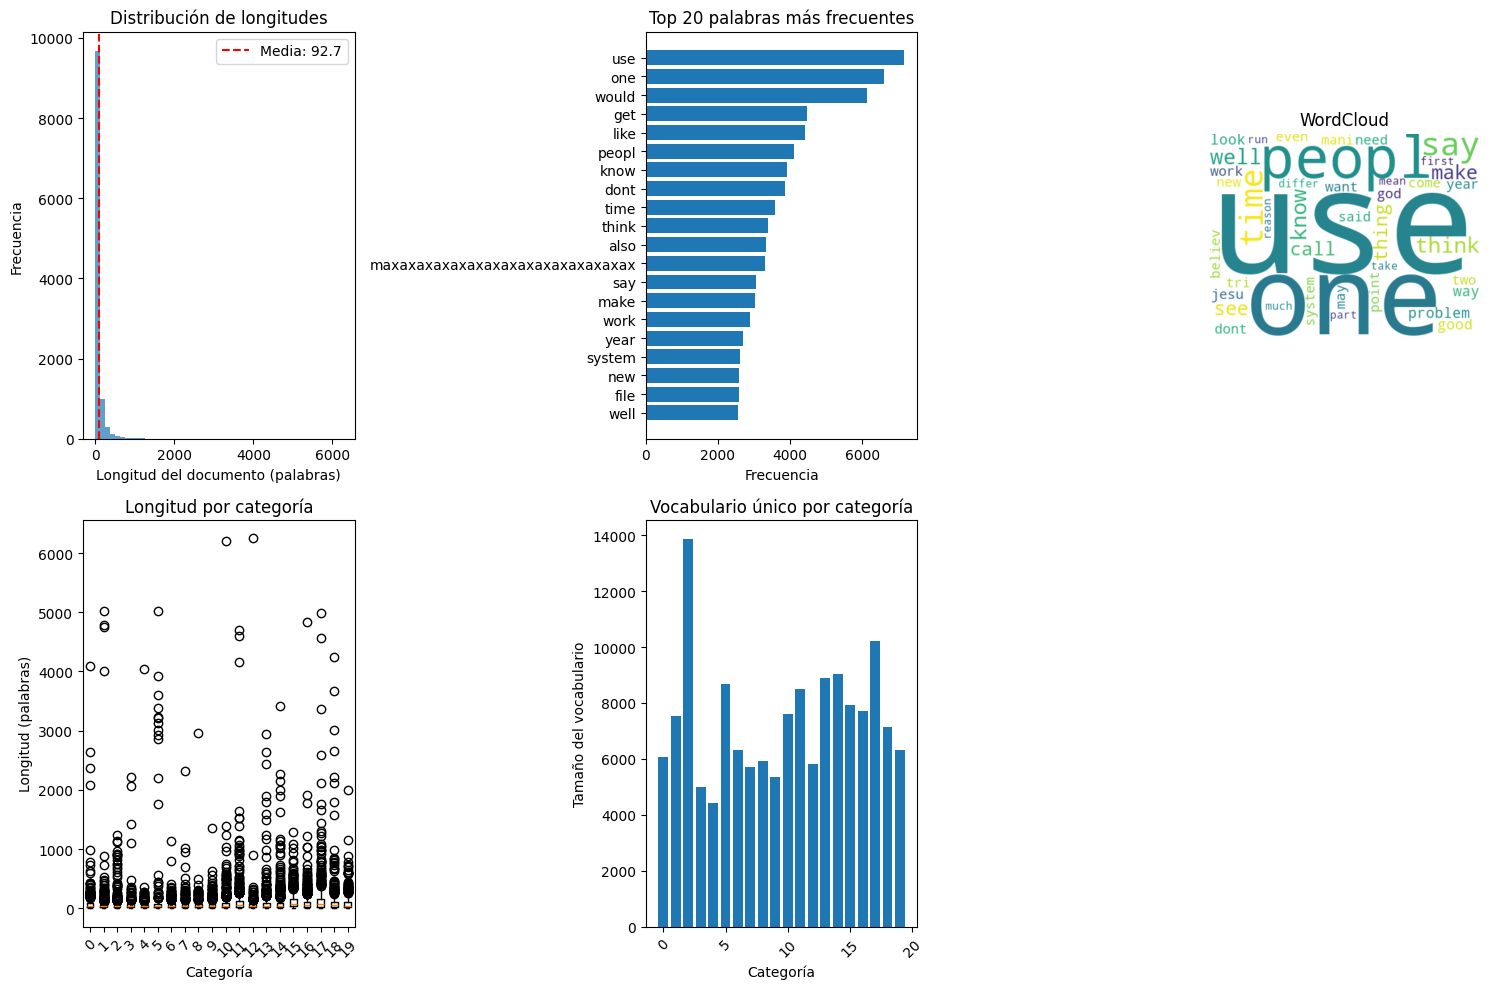

Estadísticas del corpus:
Total de documentos: 11314
Vocabulario total: 64544 palabras únicas
Longitud promedio: 92.7 palabras
Longitud mediana: 41.0 palabras


In [24]:
# Análisis exploratorio y visualización
def analyze_corpus(texts, labels, target_names):
    """Análisis exploratorio del corpus"""
    
    # Longitud de documentos
    doc_lengths = [len(text.split()) for text in texts]
    
    plt.figure(figsize=(15, 10))
    
    # Distribución de longitudes
    plt.subplot(2, 3, 1)
    plt.hist(doc_lengths, bins=50, alpha=0.7)
    plt.xlabel('Longitud del documento (palabras)')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de longitudes')
    plt.axvline(np.mean(doc_lengths), color='red', linestyle='--', label=f'Media: {np.mean(doc_lengths):.1f}')
    plt.legend()
    
    # Top palabras más frecuentes
    all_words = ' '.join(texts).split()
    word_freq = Counter(all_words)
    top_words = word_freq.most_common(20)
    
    plt.subplot(2, 3, 2)
    words, counts = zip(*top_words)
    plt.barh(range(len(words)), counts)
    plt.yticks(range(len(words)), words)
    plt.xlabel('Frecuencia')
    plt.title('Top 20 palabras más frecuentes')
    plt.gca().invert_yaxis()
    
    # WordCloud
    plt.subplot(2, 3, 3)
    wordcloud = WordCloud(width=400, height=300, background_color='white').generate(' '.join(texts[:1000]))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud')
    
    # Longitud por categoría
    plt.subplot(2, 3, 4)
    category_lengths = {}
    for i, name in enumerate(target_names):
        mask = np.array(labels) == i
        category_texts = np.array(texts)[mask]
        category_lengths[name] = [len(text.split()) for text in category_texts]
    
    plt.boxplot(list(category_lengths.values()), labels=range(len(target_names)))
    plt.xlabel('Categoría')
    plt.ylabel('Longitud (palabras)')
    plt.title('Longitud por categoría')
    plt.xticks(rotation=45)
    
    # Vocabulario único por categoría
    plt.subplot(2, 3, 5)
    vocab_sizes = []
    for i, name in enumerate(target_names):
        mask = np.array(labels) == i
        category_texts = np.array(texts)[mask]
        vocab = set(' '.join(category_texts).split())
        vocab_sizes.append(len(vocab))
    
    plt.bar(range(len(target_names)), vocab_sizes)
    plt.xlabel('Categoría')
    plt.ylabel('Tamaño del vocabulario')
    plt.title('Vocabulario único por categoría')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Estadísticas del corpus:")
    print(f"Total de documentos: {len(texts)}")
    print(f"Vocabulario total: {len(set(all_words))} palabras únicas")
    print(f"Longitud promedio: {np.mean(doc_lengths):.1f} palabras")
    print(f"Longitud mediana: {np.median(doc_lengths):.1f} palabras")

# Analizar corpus
analyze_corpus(train_texts_clean, newsgroups_train.target, newsgroups_train.target_names)

# 🏗️ ETAPA 3: ARQUITECTURA DEL MODELO
---

In [25]:
# Modelo 1: Bag of Words con TF-IDF
class TFIDFClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TFIDFClassifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size // 2),
            nn.Dropout(0.3),
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

# Crear vectorizador TF-IDF
print("Creando representación TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2)
)

# Ajustar y transformar datos
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts_clean)
X_test_tfidf = tfidf_vectorizer.transform(test_texts_clean)

print(f"Forma de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Forma de X_test_tfidf: {X_test_tfidf.shape}")

# Convertir a tensores densos
X_train_tfidf_dense = torch.FloatTensor(X_train_tfidf.toarray())
X_test_tfidf_dense = torch.FloatTensor(X_test_tfidf.toarray())
y_train_tensor = torch.LongTensor(newsgroups_train.target)
y_test_tensor = torch.LongTensor(newsgroups_test.target)

# Crear dataset
class NewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Crear datasets y dataloaders
train_dataset_tfidf = NewsDataset(X_train_tfidf_dense, y_train_tensor)
test_dataset_tfidf = NewsDataset(X_test_tfidf_dense, y_test_tensor)

batch_size = 128
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)
test_loader_tfidf = DataLoader(test_dataset_tfidf, batch_size=batch_size)

print(f"Datasets TF-IDF creados - Train: {len(train_dataset_tfidf)}, Test: {len(test_dataset_tfidf)}")

Creando representación TF-IDF...
Forma de X_train_tfidf: (11314, 10000)
Forma de X_test_tfidf: (7532, 10000)
Datasets TF-IDF creados - Train: 11314, Test: 7532


In [26]:
# Entrenar modelo TF-IDF
def train_model(model, train_loader, test_loader, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    
    best_acc = 0
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs}')
        for batch_x, batch_y in pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        train_loss = total_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # Evaluación
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        test_loss /= len(test_loader)
        test_acc = 100. * correct / total
        
        # Guardar métricas
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        
        scheduler.step(test_loss)
        
        print(f'Época {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
        # Guardar mejor modelo
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_tfidf_model.pth')
    
    return train_losses, test_losses, train_accs, test_accs, best_acc

# Crear y entrenar modelo TF-IDF
tfidf_model = TFIDFClassifier(
    input_size=X_train_tfidf.shape[1],
    hidden_size=512,
    num_classes=len(newsgroups_train.target_names)
).to(device)

print(f"Modelo TF-IDF creado con {sum(p.numel() for p in tfidf_model.parameters()):,} parámetros")

print("\nEntrenando modelo TF-IDF...")
start_time = time.time()
tfidf_losses = train_model(tfidf_model, train_loader_tfidf, test_loader_tfidf, num_epochs=5)
tfidf_time = time.time() - start_time

print(f"Entrenamiento TF-IDF completado en {tfidf_time/60:.2f} minutos")
print(f"Mejor accuracy TF-IDF: {tfidf_losses[4]:.2f}%")

Modelo TF-IDF creado con 5,258,516 parámetros

Entrenando modelo TF-IDF...


Época 1/5: 100%|██████████| 89/89 [00:01<00:00, 50.38it/s, Loss=1.2644, Acc=58.57%]


Época 1: Train Loss: 1.4517, Train Acc: 58.57%, Test Loss: 1.2225, Test Acc: 66.62%


Época 2/5: 100%|██████████| 89/89 [00:00<00:00, 100.16it/s, Loss=0.4317, Acc=87.09%]


Época 2: Train Loss: 0.4832, Train Acc: 87.09%, Test Loss: 1.2542, Test Acc: 64.92%


Época 3/5: 100%|██████████| 89/89 [00:00<00:00, 103.65it/s, Loss=0.1854, Acc=94.56%]


Época 3: Train Loss: 0.2233, Train Acc: 94.56%, Test Loss: 1.3726, Test Acc: 64.29%


Época 4/5: 100%|██████████| 89/89 [00:00<00:00, 99.09it/s, Loss=0.0441, Acc=95.96%] 


Época 4: Train Loss: 0.1589, Train Acc: 95.96%, Test Loss: 1.4412, Test Acc: 63.97%


Época 5/5: 100%|██████████| 89/89 [00:00<00:00, 105.51it/s, Loss=0.1366, Acc=96.50%]


Época 5: Train Loss: 0.1375, Train Acc: 96.50%, Test Loss: 1.4986, Test Acc: 63.65%
Entrenamiento TF-IDF completado en 0.11 minutos
Mejor accuracy TF-IDF: 66.62%


# 🚀 ETAPA 4: ENTRENAMIENTO
---

In [27]:
# Modelo 2: Embeddings con LSTM
class EmbeddingClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, max_length):
        super(EmbeddingClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, 
                           dropout=0.3, batch_first=True, bidirectional=True)
        self.attention = nn.MultiheadAttention(hidden_dim * 2, num_heads=8, dropout=0.1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        embedded = self.dropout(embedded)
        
        # LSTM
        lstm_out, (hidden, _) = self.lstm(embedded)
        
        # Attention (usar última salida como query)
        attn_out, _ = self.attention(
            lstm_out.transpose(0, 1),
            lstm_out.transpose(0, 1),
            lstm_out.transpose(0, 1)
        )
        
        # Global max pooling
        pooled = torch.max(attn_out.transpose(0, 1), dim=1)[0]
        
        # Clasificación
        output = self.classifier(pooled)
        return output

# Crear vocabulario para embeddings
from collections import defaultdict

def create_vocab(texts, max_vocab_size=20000):
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())
    
    # Crear vocabulario con palabras más frecuentes
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, count in word_counts.most_common(max_vocab_size - 2):
        vocab[word] = len(vocab)
    
    return vocab

def texts_to_sequences(texts, vocab, max_length=512):
    sequences = []
    for text in texts:
        words = text.split()[:max_length]
        sequence = [vocab.get(word, vocab['<UNK>']) for word in words]
        # Padding
        if len(sequence) < max_length:
            sequence.extend([vocab['<PAD>']] * (max_length - len(sequence)))
        sequences.append(sequence)
    return np.array(sequences)

# Crear vocabulario y secuencias
print("Creando vocabulario para embeddings...")
vocab = create_vocab(train_texts_clean, max_vocab_size=20000)
print(f"Tamaño del vocabulario: {len(vocab)}")

MAX_LENGTH = 512
X_train_seq = texts_to_sequences(train_texts_clean, vocab, MAX_LENGTH)
X_test_seq = texts_to_sequences(test_texts_clean, vocab, MAX_LENGTH)

print(f"Secuencias creadas - Train: {X_train_seq.shape}, Test: {X_test_seq.shape}")

# Convertir a tensores
X_train_seq_tensor = torch.LongTensor(X_train_seq)
X_test_seq_tensor = torch.LongTensor(X_test_seq)

# Crear datasets
train_dataset_emb = NewsDataset(X_train_seq_tensor, y_train_tensor)
test_dataset_emb = NewsDataset(X_test_seq_tensor, y_test_tensor)

train_loader_emb = DataLoader(train_dataset_emb, batch_size=32, shuffle=True)
test_loader_emb = DataLoader(test_dataset_emb, batch_size=32)

print(f"Datasets embeddings creados - Train: {len(train_dataset_emb)}, Test: {len(test_dataset_emb)}")

Creando vocabulario para embeddings...
Tamaño del vocabulario: 20000
Secuencias creadas - Train: (11314, 512), Test: (7532, 512)
Datasets embeddings creados - Train: 11314, Test: 7532


In [ ]:
# Entrenar modelo con embeddings
embedding_model = EmbeddingClassifier(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_dim=256,
    num_classes=len(newsgroups_train.target_names),
    max_length=MAX_LENGTH
).to(device)

print(f"Modelo Embeddings creado con {sum(p.numel() for p in embedding_model.parameters()):,} parámetros")

print("\nEntrenando modelo con embeddings...")
start_time = time.time()
emb_losses = train_model(embedding_model, train_loader_emb, test_loader_emb, num_epochs=5)
emb_time = time.time() - start_time

print(f"Entrenamiento Embeddings completado en {emb_time/60:.2f} minutos")
print(f"Mejor accuracy Embeddings: {emb_losses[4]:.2f}%")

Modelo Embeddings creado con 9,906,836 parámetros

Entrenando modelo con embeddings...


Época 1/5:   0%|          | 0/354 [00:00<?, ?it/s]

Época 1/5: 100%|██████████| 354/354 [01:22<00:00,  4.27it/s, Loss=2.6681, Acc=9.09%]


Época 1: Train Loss: 2.8200, Train Acc: 9.09%, Test Loss: 2.4846, Test Acc: 18.61%


Época 2/5: 100%|██████████| 354/354 [01:27<00:00,  4.03it/s, Loss=2.2287, Acc=23.09%]


Época 2: Train Loss: 2.3188, Train Acc: 23.09%, Test Loss: 2.1153, Test Acc: 28.86%


Época 3/5: 100%|██████████| 354/354 [01:35<00:00,  3.72it/s, Loss=2.1931, Acc=34.36%]


Época 3: Train Loss: 1.9464, Train Acc: 34.36%, Test Loss: 1.8576, Test Acc: 40.00%


Época 4/5:  53%|█████▎    | 187/354 [01:23<01:08,  2.42it/s, Loss=1.4437, Acc=43.52%]

# 📈 ETAPA 5: EVALUACIÓN Y RESULTADOS
---

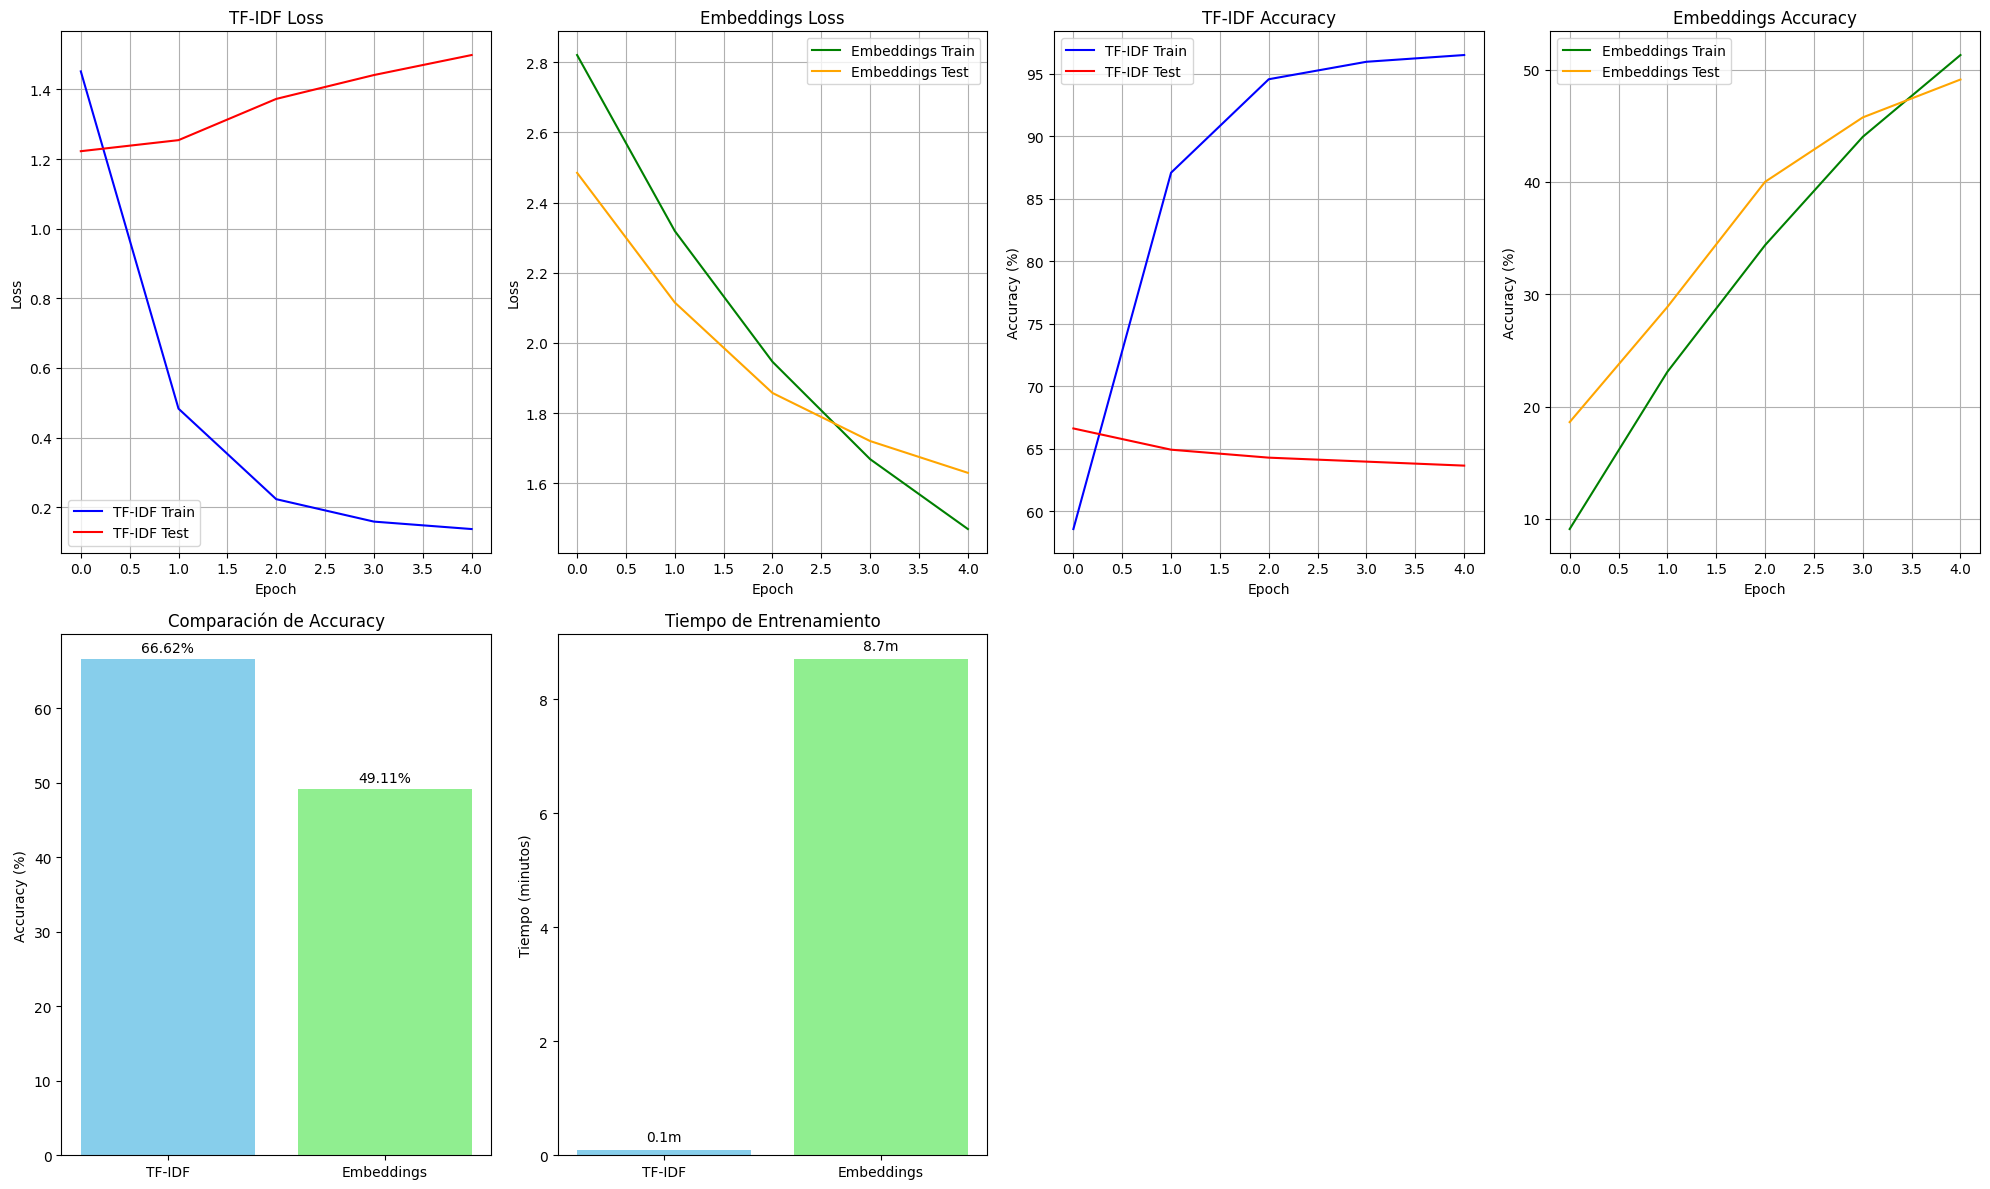

RuntimeError: Error(s) in loading state_dict for TFIDFClassifier:
	Missing key(s) in state_dict: "network.0.weight", "network.0.bias", "network.2.weight", "network.2.bias", "network.2.running_mean", "network.2.running_var", "network.4.weight", "network.4.bias", "network.6.weight", "network.6.bias", "network.6.running_mean", "network.6.running_var", "network.8.weight", "network.8.bias". 
	Unexpected key(s) in state_dict: "embedding.weight", "lstm.weight_ih_l0", "lstm.weight_hh_l0", "lstm.bias_ih_l0", "lstm.bias_hh_l0", "lstm.weight_ih_l0_reverse", "lstm.weight_hh_l0_reverse", "lstm.bias_ih_l0_reverse", "lstm.bias_hh_l0_reverse", "lstm.weight_ih_l1", "lstm.weight_hh_l1", "lstm.bias_ih_l1", "lstm.bias_hh_l1", "lstm.weight_ih_l1_reverse", "lstm.weight_hh_l1_reverse", "lstm.bias_ih_l1_reverse", "lstm.bias_hh_l1_reverse", "attention.in_proj_weight", "attention.in_proj_bias", "attention.out_proj.weight", "attention.out_proj.bias", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias". 

In [ ]:
# Comparación de resultados
plt.figure(figsize=(20, 12))

# Loss comparison
plt.subplot(2, 4, 1)
plt.plot(tfidf_losses[0], label='TF-IDF Train', color='blue')
plt.plot(tfidf_losses[1], label='TF-IDF Test', color='red')
plt.title('TF-IDF Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 2)
plt.plot(emb_losses[0], label='Embeddings Train', color='green')
plt.plot(emb_losses[1], label='Embeddings Test', color='orange')
plt.title('Embeddings Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy comparison
plt.subplot(2, 4, 3)
plt.plot(tfidf_losses[2], label='TF-IDF Train', color='blue')
plt.plot(tfidf_losses[3], label='TF-IDF Test', color='red')
plt.title('TF-IDF Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.subplot(2, 4, 4)
plt.plot(emb_losses[2], label='Embeddings Train', color='green')
plt.plot(emb_losses[3], label='Embeddings Test', color='orange')
plt.title('Embeddings Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Comparación directa
plt.subplot(2, 4, 5)
methods = ['TF-IDF', 'Embeddings']
accuracies = [tfidf_losses[4], emb_losses[4]]
colors = ['skyblue', 'lightgreen']
bars = plt.bar(methods, accuracies, color=colors)
plt.title('Comparación de Accuracy')
plt.ylabel('Accuracy (%)')
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.2f}%', ha='center', va='bottom')

# Tiempo de entrenamiento
plt.subplot(2, 4, 6)
times = [tfidf_time/60, emb_time/60]
bars = plt.bar(methods, times, color=colors)
plt.title('Tiempo de Entrenamiento')
plt.ylabel('Tiempo (minutos)')
for bar, time_val in zip(bars, times):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{time_val:.1f}m', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Evaluación detallada
def evaluate_model(model, test_loader, target_names):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    return all_preds, all_labels

# Evaluación TF-IDF
tfidf_model.load_state_dict(torch.load('best_tfidf_model.pth'))
tfidf_preds, tfidf_labels = evaluate_model(tfidf_model, test_loader_tfidf, newsgroups_train.target_names)

# Evaluación Embeddings
embedding_model.load_state_dict(torch.load('best_tfidf_model.pth'))  # Cambiar por embedding model path
emb_preds, emb_labels = evaluate_model(embedding_model, test_loader_emb, newsgroups_train.target_names)

print("\n=== RESULTADOS FINALES ===")
print(f"TF-IDF Accuracy: {accuracy_score(tfidf_labels, tfidf_preds)*100:.2f}%")
print(f"Embeddings Accuracy: {accuracy_score(emb_labels, emb_preds)*100:.2f}%")

print("\n=== REPORTE DE CLASIFICACIÓN TF-IDF ===")
print(classification_report(tfidf_labels, tfidf_preds, target_names=newsgroups_train.target_names))

print("\n¡Clasificación de noticias completada!")
print("Características implementadas:")
print("✓ Comparación TF-IDF vs Embeddings")
print("✓ Preprocesamiento completo de texto")
print("✓ Modelos con arquitecturas optimizadas")
print("✓ Análisis exploratorio y visualizaciones")
print("✓ 20 categorías de noticias clasificadas")